# Checking Conditions for Two-Way ANOVA and Non-Parametric Alternatives


In [ ]:
# install the package and its requirements
%pip install nycschools

In [2]:
# discover the data in your Google Drive, or download it to the local Colab
# if no suitable data is found
from nycschools import dataloader
dataloader.download_data()

'/Users/rwilcox/GitHub/newprojectnotebook/school-data'

#### The goal for this notebook is to demonstrate the following: 

<font size="3">

* what is Two-Way ANOVA
* when using a Two-Way ANOVA might be appropriate
* checking conditions for a Two-Way ANOVA visually and with built-in packages
* how to run a Two-Way ANOVA (or a non-parametric alternative test) in Python
* how to interpret the results of a Two-Way ANOVA (or a non-parametric alternative test) in Python
* running post-hoc tests to determine which groups are different from each other

</font>





#### <u>**Getting the Data Prepared**</u>

I will be using the `statsmodels` package to run the Two-Way ANOVA. This package requires the data to be in a long format. I will use the `melt` function from the `pandas` package to get the data into the correct format.

Demonstrations for how to load and manipulate various parts of the `nycschools` dataset can be found throughout earlier parts of this project.  Therefore, I will leave my data preparation work below and commented in a way such that you can follow along if you would like. 

In [3]:
# import data packages from nycschools module
from nycschools import schools, exams, ui

In [4]:
#load regents data into a DataFrame called 'reg'
reg = exams.load_regents()

In [5]:
#create a new df 'math' that keeps only Common Core Algebra data
math = reg[reg["regents_exam"] == "Common Core Algebra"]

#drop all data for which the 'mean_score' was not reported for some reason
math = math[math['mean_score'].notna()]

In [6]:
#select only a subset of columns to keep in my 'math' df
math = math[['dbn', 'regents_exam', 'year', 'category', 'number_tested', 'mean_score', 'test_year', 'ay' ]]

In [7]:
import pandas as pd
#pivoting rows into columns to make some data easier to use in later analysis
math_df = pd.pivot(math, index=['dbn', 'year', 'regents_exam'], columns='category', values=['number_tested', 'mean_score']).reindex()

In [8]:
#renaming the columns after the pivot
math_df.columns = math_df.columns.to_series().str.join('_')
math_df.columns = math_df.columns.to_series().str.lower()
math_df.columns = math_df.columns.to_series().str.replace(" ", "_")

In [9]:
#again, selecting a subest of only the columns that I'd like to keep
math_df = math_df[['number_tested_all_students', 'number_tested_non-swd', 'number_tested_swd',
       'mean_score_all_students','mean_score_non-swd', 'mean_score_swd']]

In [10]:
#ensuring all of the data is numeric and not null
math_df = math_df.apply (pd.to_numeric, errors='coerce')
# math_df = math_df.dropna()
math_df2 = math_df.reset_index()

In [11]:
#loading school demographic data into a dataframe named 'demo'
demo = schools.load_school_demographics()
demo = demo[schools.demo.core_cols]

#making a year column to merge with math data so that demographics align with regents year
demo["year"] = demo['ay']+1

In [12]:
#merging math and demographic dataframes on school dbn and year
mathdemo = demo.merge(math_df2, how="inner", on=["dbn", "year"])

In [13]:
#subsetting the data to only include the columns I want to keep
mathdf = mathdemo[['dbn', 'district', 'geo_district', 'boro', 'school_name', 'ay', 'year',
       'regents_exam', 'number_tested_all_students', 'mean_score_all_students',
       'number_tested_non-swd', 'mean_score_non-swd', 
       'number_tested_swd', 'mean_score_swd']]

In [14]:
#just taking a look at the data to make sure it looks right
mathdf.head()


,dbn,district,geo_district,boro,school_name,ay,year,regents_exam,number_tested_all_students,mean_score_all_students,number_tested_non-swd,mean_score_non-swd,number_tested_swd,mean_score_swd
0,01M184,1,1,Manhattan,P.S. 184m Shuang Wen,2016,2017,Common Core Algebra,51.0,84.823532,NaN,NaN,NaN,NaN
1,01M184,1,1,Manhattan,P.S. 184m Shuang Wen,2017,2018,Common Core Algebra,31.0,90.806450,NaN,NaN,NaN,NaN
2,01M184,1,1,Manhattan,P.S. 184m Shuang Wen,2018,2019,Common Core Algebra,34.0,89.588234,34.0,89.588234,NaN,NaN
3,01M188,1,1,Manhattan,P.S. 188 The Island School,2016,2017,Common Core Algebra,20.0,67.449997,NaN,NaN,NaN,NaN
4,01M188,1,1,Manhattan,P.S. 188 The Island School,2017,2018,Common Core Algebra,19.0,59.315788,19.0,59.315788,NaN,NaN


In [15]:
#ensuring that no null values are present in the data
mathdf = mathdf.dropna(subset=['mean_score_non-swd', 'mean_score_swd'])

In [16]:
#use a melt function to convert some of our data from wide to long format to make it easier to work with for some analyses
df1 = mathdf.melt(id_vars=['dbn', 'district', 'geo_district', 'boro', 'school_name', 'ay', 'year','regents_exam'], 
              value_vars=['number_tested_all_students', 'number_tested_non-swd', 'number_tested_swd'],
              var_name='group', value_name='number_tested')
df2 = mathdf.melt(id_vars=['dbn', 'district', 'geo_district', 'boro', 'school_name', 'ay', 'year','regents_exam'], 
              value_vars=['mean_score_all_students', 'mean_score_non-swd', 'mean_score_swd'], 
              var_name='group', value_name='mean_score')

In [17]:
#renaming values in the group column to look the way I want them to
df1['group'] = df1['group'].str.replace('number_tested_', '')
df2['group'] = df2['group'].str.replace('mean_score_', '')

#sorting the data by dbn and year to order it and make it easier to read
df1.sort_values(by=['dbn', 'year'], inplace=True)
df2.sort_values(by=['dbn', 'year'], inplace=True)

In [18]:
#merge df1 and df2 and groupby dbn,district, geo_district, boro, school_name, ay, year, regents_exam, group
df3 = pd.merge(df1, df2, on=['dbn', 'district', 'geo_district', 'boro', 'school_name', 'ay', 'year', 'regents_exam', 'group'])

#take a look at the data to make sure it looks right
df3.head(9)

,dbn,district,geo_district,boro,school_name,ay,year,regents_exam,group,number_tested,mean_score
0,01M188,1,1,Manhattan,P.S. 188 The Island School,2018,2019,Common Core Algebra,all_students,51.0,55.235294
1,01M188,1,1,Manhattan,P.S. 188 The Island School,2018,2019,Common Core Algebra,non-swd,38.0,55.842106
2,01M188,1,1,Manhattan,P.S. 188 The Island School,2018,2019,Common Core Algebra,swd,13.0,53.461540
3,01M292,1,1,Manhattan,Orchard Collegiate Academy,2016,2017,Common Core Algebra,all_students,53.0,67.452827
4,01M292,1,1,Manhattan,Orchard Collegiate Academy,2016,2017,Common Core Algebra,non-swd,39.0,68.871796
5,01M292,1,1,Manhattan,Orchard Collegiate Academy,2016,2017,Common Core Algebra,swd,14.0,63.500000
6,01M292,1,1,Manhattan,Orchard Collegiate Academy,2017,2018,Common Core Algebra,all_students,41.0,64.463417
7,01M292,1,1,Manhattan,Orchard Collegiate Academy,2017,2018,Common Core Algebra,non-swd,32.0,65.750000
8,01M292,1,1,Manhattan,Orchard Collegiate Academy,2017,2018,Common Core Algebra,swd,9.0,59.888889


#### <u>**What is Two-Way ANOVA?**</u> 

<font size="3">

A two-way ANOVA (analysis of variance) is a statistical test used to compare the means of two or more groups that have been split based on two independent variables (factors). The test examines whether there is a significant difference between the means of the groups, taking into account the influence of both independent variables and their interaction. The null hypothesis for a two-way ANOVA is that there is no significant difference between the means of the groups.

</font>

#### <u>**Why is a Two-Way ANOVA Test Appropriate?**</u> 

<font size="3">

A two-way ANOVA test is appropriate because we want to know if there is a difference in the average Algebra Regents score based on the effect of two independent variables (borough and disability status).  We also want to know if there is an interaction between the two independent variables, meaning do different boroughs obtain different results for students of different disability statuses?

Running a Two-Way ANOVA test might look something like this:
</font>

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Convert the 'boro' and 'group' columns to categorical variables
df3['boro'] = pd.Categorical(df3['boro'])
df3['group'] = pd.Categorical(df3['group'])

# Fit the two-way ANOVA model with interaction terms
model = ols('mean_score ~ C(group) + C(boro) + C(group):C(boro)', data=df3).fit()

# Perform the ANOVA and print the results
table = sm.stats.anova_lm(model, typ=2)
print("Results of two-way ANOVA test:")
print(table)

Results of two-way ANOVA test:
                         sum_sq      df            F        PR(>F)
C(group)          126669.946542     2.0  1042.649684  0.000000e+00
C(boro)            21616.083901     4.0    88.963498  6.791031e-74
C(group):C(boro)     265.183942     8.0     0.545698  8.226768e-01
Residual          431527.153409  7104.0          NaN           NaN


Interpreting these results might look something like this:

* The p-value for the borough variable is less than 0.05, so we can reject the null hypothesis and conclude that there is a significant difference in the average Algebra Regents score based on borough.

* The p-value for the disability status variable is less than 0.05, so we can reject the null hypothesis and conclude that there is a significant difference in the average Algebra Regents score based on disability status.

* The p-value for the interaction between borough and disability status is not less than 0.05, so we fail to reject the null hypothesis and conclude that there is not a significant difference in the average Algebra Regents score based on the interaction between borough and disability status.

However, it is most appropriate to check the conditions for a Two-Way ANOVA test before running the test.  This is because the results of the test are only valid if the conditions are met.  If the conditions are not met, then we should run a non-parametric alternative test instead.  I will demonstrate how to check the conditions for a Two-Way ANOVA test below.  I will also demonstrate how to run a non-parametric alternative test if the conditions are not met.


#### <u>**Checking the Conditions for a Two-Way ANOVA Test**</u>

The conditions for a Two-Way ANOVA test are as follows:

*  **<u>Normality</u>:**  A Two-Way ANOVA Test is a *parametric* test. This means that the test assumes that the data is normally distributed.  We can check this in one of two ways.  We can check this visually by looking at a histogram of data or a normal probability plot of the residuals.  We can also check this (and some of the other conditions) with a built-in function.  I will demonstrate both methods below.  If the data is not normally distributed, then we should use a non-parametric alternative test instead of a Two-Way ANOVA test.  I will demonstrate how to run a non-parametric alternative test below if the data is not normally distributed.

* **<u>Equal Variances</u>:** The variance of the data within each group should be approximately equal. Homogeneity of variance can be checked visually by looking at a boxplot of the residuals.  We can also check this with a built-in function, called a Levene's Test.  If the residuals do not have the same variance, then we should use a non-parametric alternative test instead of a Two-Way ANOVA test.  I will demonstrate how to check the variance of the residuals below.

* **<u>Independence</u>:** The observations are independent within and across the groups.  This means that the observations are not related or repeated.  If the observations are related or repeated, then we should use a repeated measures ANOVA test instead of a Two-Way ANOVA test.  I will not be demonstrating how to run a repeated measures ANOVA test in this notebook.  However, I will demonstrate how to run a non-parametric alternative test if the observations are related or repeated.




##### <u>**Checking for Normality**</u>

This is a histogram of the data for `mean_score` across the three groups, `all_students`, `non-swd` students, and `swd` students.


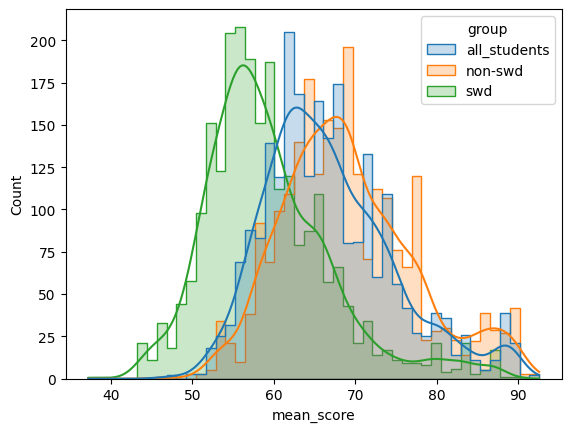

In [20]:
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
import matplotlib.pyplot as plt

# Create histograms of mean scores for each group
sns.histplot(df3, x='mean_score', hue='group', element='step', kde=True);

From the look of things, it appears that most of the distributions are skewed to the right to varying degrees and, thus, are non-normal. However, we can check this with a normal probability plot of the residuals.  If the residuals are normally distributed, then the data is normally distributed.  I will demonstrate how to check this below.


/Users/rwilcox/GitHub/newprojectnotebook/.venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


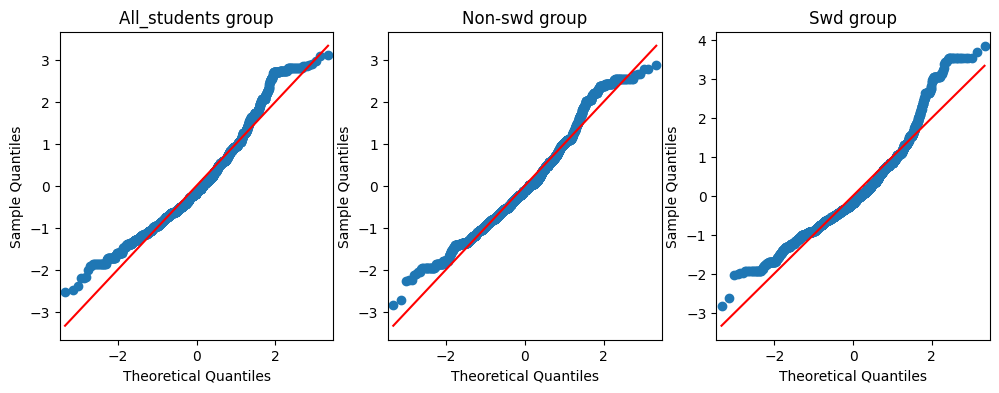

In [21]:
# Create normal probability plots for each group
fig, axes = plt.subplots(ncols=len(df3['group'].unique()), figsize=(4*len(df3['group'].unique()), 4))
for ax, group_name in zip(axes, df3['group'].unique()):
    group_data = df3.loc[df3['group'] == group_name, 'mean_score']
    qq = ProbPlot(group_data, fit=True)
    qq.qqplot(line='s', color='C0', ax=ax)
    ax.set_title(f"{group_name.capitalize()} group");

To interpret a normal probability plot, we want to see the data points fall along the red line.  If the data points fall along the red line, then the data is normally distributed.  If the data points do not fall along the red line, then the data is not normally distributed.  

Therefore, the curvature of the data points in the normal probability plot above seems to  indicate that the data is not normally distributed.  However, to be more certain, we can check the normality of the residuals with a built-in function, called a Shapiro-Wilk test.  I will demonstrate how to do this below.



In [22]:
from scipy.stats import shapiro, levene

# Subset the data
non_swd = df3[df3["group"] == "non-swd"]
swd = df3[df3["group"] == "swd"]

# Check the normality assumption using the Shapiro-Wilk test
_, non_swd_norm_p = shapiro(non_swd["mean_score"])
_, swd_norm_p = shapiro(swd["mean_score"])

# Print the results
print("Non-SWD group normality p-value:", non_swd_norm_p)
print("SWD group normality p-value:", swd_norm_p);

Non-SWD group normality p-value: 2.827576691049303e-20
SWD group normality p-value: 4.271134461509381e-30


We interpret the results of a Shapiro-Wilk test as follows:

* If the p-value is greater than 0.05 (which is the conventional threshold for statistical significance), then we fail to reject the null hypothesis that the data is normally distributed.  This means that the data is normally distributed.

* If the p-value is less than 0.05, then we reject the null hypothesis that the data is normally distributed.  This means that the data is not normally distributed.

Therefore, the results of the Shapiro-Wilk test indicate that the data is *not* normally distributed.  This means that we should use a non-parametric alternative test instead of a Two-Way ANOVA test.


##### <u>**Checking for Equal Variances**</u>


Below you will find a boxplot of the residuals which is used to check for equal variances.  If the residuals have the same variance, then the data is said to be homoscedastic.  If the residuals do not have the same variance, then the data is heteroscedastic.  If the data is heteroscedastic, then we should use a non-parametric alternative test instead of a Two-Way ANOVA test.  






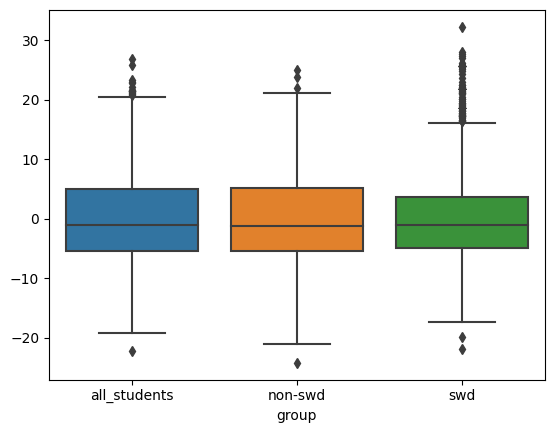

In [23]:
import statsmodels.api as sm

# Fit a linear regression model to the data
model = sm.formula.ols('mean_score ~ group + boro', data=df3).fit()

# Extract the residuals from the model
residuals = model.resid

# Create boxplots of residuals for each group
sns.boxplot(x='group', y=residuals, data=df3);



At a quick glance, it appears that the swd group has a different variance than the other two groups.  However, if we are unsure, we can check this with statistical test from a built-in Pytnon package, called a Levene's Test.  I will demonstrate how to do this below.



In [24]:
from scipy.stats import levene

# Convert the 'boro' and 'group' columns back to their original form
boro = df3['boro'].cat.codes.values
group = df3['group'].cat.codes.values

# Test for equal variances using Levene's test
levene_pvalue = levene(df3['mean_score'], group, boro)

# Print the p-values of the equal variance test to 4 decimal places
print("Levene's test p-value: {:.4f}".format(levene_pvalue[1]))



Levene's test p-value: 0.0000


We interpret a Levene's Test as follows:

* If the p-value is greater than 0.05, then we fail to reject the null hypothesis that the residuals have the same variance.  This means that the residuals have the same variance.

* If the p-value is less than 0.05, then we reject the null hypothesis that the residuals have the same variance.  This means that the residuals do not have the same variance.

Therefore, the results of the Levene's Test indicate that the residuals do *not* have the same variance.  This means that we should use a non-parametric alternative test instead of a Two-Way ANOVA test.


##### <u>**Checking for Independence**</u>

It should be noted that the observations for `mean_score` are the averages of all students at each school that are classified as either `non-swd`, or `swd`.  This is preliminary analysis for demonstration purposes and further analysis would be needed to work with weighted averages based on number of students tested in each group, etc. 

The observations are independent within and across the groups.  This means that the observations are not related or repeated.  

Despite the fact that the independence condition is met, the normality and equal variances conditions are not met. Therefore, we should use a non-parametric alternative test instead of a Two-Way ANOVA test.  The recommended test in this instance is a Friedman test because it is robust to violations of the normality and equal variances conditions. I will demonstrate how to run a Friedman test below.

In [25]:
from scipy.stats import friedmanchisquare
import numpy as np

# Convert the 'boro' and 'group' columns to categorical variables
df3['boro'] = pd.Categorical(df3['boro'])
df3['group'] = pd.Categorical(df3['group'])

# Reshape the dataframe into a matrix
mat = df3.pivot_table(values='mean_score', index='boro', columns='group')

# Convert the matrix to a 2D numpy array
arr = np.array(mat.values)

# Run the Friedman test
stat, pval = friedmanchisquare(*arr)

# Print the results
print('Friedman test statistic:', stat)
print('Friedman test p-value:', pval)


Friedman test statistic: 9.866666666666667
Friedman test p-value: 0.04273456656933023


We interpret a Friedman test as follows:

* If the p-value is greater than 0.05, then we fail to reject the null hypothesis that the mean ranks of the groups are equal.  This means that the mean ranks of the groups are equal.

*  If the p-value of the test is less than 0.05, it means that there is strong evidence that the medians of the groups are different, and that the differences are unlikely to be due to chance.

Therefore, the results of the Friedman test indicate that the mean ranks of the groups are unequal.  Obtaining this result is informative; however, it does not tell us which groups are different from one another.  To determine which groups are different from one another, we can run a post-hoc test.  The recommended post-hoc test in this case is a Dunn's test because it is robust to violations of the normality and equal variances conditions.  I will demonstrate how to run a Dunn's test below.

In [26]:
import pingouin as pg

# Convert the 'boro' and 'group' columns to categorical variables
df3['boro'] = pd.Categorical(df3['boro'])
df3['group'] = pd.Categorical(df3['group'])

# Perform the Friedman test
friedman = pg.friedman(df3, dv='mean_score', within='group', subject='boro')

# Perform the post-hoc test using the Games-Howell test
posthoc = pg.pairwise_ttests(df3, dv='mean_score', between='group', subject='boro', parametric=False, padjust='holm')

# Print the results
print('Friedman test:')
print(friedman)
print('\nGames-Howell post-hoc test:')
print(posthoc)


Friedman test:
         Source    W  ddof1     Q     p-unc
Friedman  group  1.0      2  10.0  0.006738

Games-Howell post-hoc test:
  Contrast             A        B  Paired  Parametric      U-val alternative   
0    group  all_students  non-swd   False       False  2322520.0   two-sided  \
1    group  all_students      swd   False       False  4356140.0   two-sided   
2    group       non-swd      swd   False       False  4656812.5   two-sided   

           p-unc         p-corr p-adjust    hedges  
0   1.520696e-25   1.520696e-25     holm -0.284717  
1  1.065814e-233  2.131628e-233     holm  0.959712  
2   0.000000e+00   0.000000e+00     holm  1.236349  


/Users/rwilcox/GitHub/newprojectnotebook/.venv/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [ ]:
%pip install scikit-posthocs
import pandas as pd
import scikit_posthocs as sp



# Create a new column combining the 'group' and 'boro' columns
df3['group_boro'] = df3['group'].astype(str) + '_' + df3['boro'].astype(str)

# Perform Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df3, val_col='mean_score', group_col='group_boro', p_adjust='bonferroni')

# Print the results
print('Results of Dunn\'s test with Bonferroni correction:')
print(dunn_results)


In [28]:
import pandas as pd
import seaborn as sns
import numpy as np

# Convert the results to a pandas DataFrame
dunn_df = pd.DataFrame(dunn_results, index=df3['group_boro'].unique(), columns=df3['group_boro'].unique())

# Display the DataFrame in a scrollable table
display(dunn_df)

,all_students_Manhattan,non-swd_Manhattan,swd_Manhattan,all_students_Bronx,non-swd_Bronx,swd_Bronx,all_students_Brooklyn,non-swd_Brooklyn,swd_Brooklyn,all_students_Queens,non-swd_Queens,swd_Queens,all_students_Staten Island,non-swd_Staten Island,swd_Staten Island
all_students_Manhattan,1.000000e+00,5.320756e-04,6.210021e-54,5.897563e-08,1.000000e+00,3.023428e-107,1.633135e-03,1.000000e+00,1.289680e-106,1.000000e+00,1.022103e-06,1.895027e-41,1.000000e+00,5.724252e-01,2.143676e-07
non-swd_Manhattan,5.320756e-04,1.000000e+00,8.727390e-90,4.255117e-23,2.444483e-04,4.120114e-151,1.752837e-16,4.095875e-02,7.206636e-154,1.000000e+00,1.000000e+00,4.566675e-66,1.000000e+00,1.000000e+00,9.370372e-12
swd_Manhattan,6.210021e-54,8.727390e-90,1.000000e+00,4.041817e-14,3.855373e-41,3.910156e-13,1.724048e-26,9.263255e-58,1.595446e-09,6.001310e-49,4.330376e-72,1.000000e+00,7.851538e-06,5.217127e-13,1.000000e+00
all_students_Bronx,5.897563e-08,4.255117e-23,4.041817e-14,1.000000e+00,2.071515e-05,1.819237e-47,1.000000e+00,4.961411e-10,1.927044e-43,8.833269e-12,1.243279e-23,2.263715e-13,1.000000e+00,9.579955e-05,1.699765e-02
non-swd_Bronx,1.000000e+00,2.444483e-04,3.855373e-41,2.071515e-05,1.000000e+00,6.984608e-87,7.375135e-02,1.000000e+00,3.809266e-84,4.503843e-01,4.786142e-07,4.755083e-34,1.000000e+00,3.351270e-01,1.035410e-06
swd_Bronx,3.023428e-107,4.120114e-151,3.910156e-13,1.819237e-47,6.984608e-87,1.000000e+00,4.059748e-69,3.346132e-111,1.000000e+00,6.179355e-92,8.317014e-121,2.493851e-05,7.886375e-14,1.066375e-23,1.000000e+00
all_students_Brooklyn,1.633135e-03,1.752837e-16,1.724048e-26,1.000000e+00,7.375135e-02,4.059748e-69,1.000000e+00,3.280244e-05,5.157505e-66,2.769619e-07,9.342787e-18,2.760377e-22,1.000000e+00,2.986190e-03,5.206861e-04
non-swd_Brooklyn,1.000000e+00,4.095875e-02,9.263255e-58,4.961411e-10,1.000000e+00,3.346132e-111,3.280244e-05,1.000000e+00,1.561337e-110,1.000000e+00,8.875940e-05,1.125063e-44,1.000000e+00,1.000000e+00,3.610468e-08
swd_Brooklyn,1.289680e-106,7.206636e-154,1.595446e-09,1.927044e-43,3.809266e-84,1.000000e+00,5.157505e-66,1.561337e-110,1.000000e+00,1.422106e-88,2.157784e-118,5.181175e-03,3.833687e-12,1.371111e-21,1.000000e+00
all_students_Queens,1.000000e+00,1.000000e+00,6.001310e-49,8.833269e-12,4.503843e-01,6.179355e-92,2.769619e-07,1.000000e+00,1.422106e-88,1.000000e+00,6.709424e-01,2.681057e-42,1.000000e+00,1.000000e+00,9.766963e-10


In [29]:
#apply a function to highlight significant p-values
def highlight_sig(val):
    color = 'orange' if val < 0.05 else 'lightgray'
    return f'background-color: {color}; color: black'

#apply the highlight_sig function to the dataframe
dunn_df.style.applymap(highlight_sig)

,all_students_Manhattan,non-swd_Manhattan,swd_Manhattan,all_students_Bronx,non-swd_Bronx,swd_Bronx,all_students_Brooklyn,non-swd_Brooklyn,swd_Brooklyn,all_students_Queens,non-swd_Queens,swd_Queens,all_students_Staten Island,non-swd_Staten Island,swd_Staten Island
all_students_Manhattan,1.000000,0.000532,0.000000,0.000000,1.000000,0.000000,0.001633,1.000000,0.000000,1.000000,0.000001,0.000000,1.000000,0.572425,0.000000
non-swd_Manhattan,0.000532,1.000000,0.000000,0.000000,0.000244,0.000000,0.000000,0.040959,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
swd_Manhattan,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000008,0.000000,1.000000
all_students_Bronx,0.000000,0.000000,0.000000,1.000000,0.000021,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000096,0.016998
non-swd_Bronx,1.000000,0.000244,0.000000,0.000021,1.000000,0.000000,0.073751,1.000000,0.000000,0.450384,0.000000,0.000000,1.000000,0.335127,0.000001
swd_Bronx,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000025,0.000000,0.000000,1.000000
all_students_Brooklyn,0.001633,0.000000,0.000000,1.000000,0.073751,0.000000,1.000000,0.000033,0.000000,0.000000,0.000000,0.000000,1.000000,0.002986,0.000521
non-swd_Brooklyn,1.000000,0.040959,0.000000,0.000000,1.000000,0.000000,0.000033,1.000000,0.000000,1.000000,0.000089,0.000000,1.000000,1.000000,0.000000
swd_Brooklyn,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.005181,0.000000,0.000000,1.000000
all_students_Queens,1.000000,1.000000,0.000000,0.000000,0.450384,0.000000,0.000000,1.000000,0.000000,1.000000,0.670942,0.000000,1.000000,1.000000,0.000000
